In [1]:
from pylab import *  
import numpy as np

In [2]:
#--- precipitable water vapor (g/cm2)
uw = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0, 3.25, 3.5, 3.75, 4.0]

#--- surface skin temperature (K)
temps = [270, 275, 280, 285, 290, 295, 300]

In [3]:
def read_sbdart_data(filename):
    f_raw = loadtxt(filename,delimiter="\t",skiprows=3,dtype='str')
    f = f_raw[::3]

    WL=[] #--- wavelength (um)
    FFV=[] #--- filter value
    TOPDN=[] #--- downwelling flux to the top of the atmosphere (TOA, W/cm2/um)
    TOPUP=[] #--- TOA upwelling flux
    TOPDIR=[] #--- TOA direct flux
    BOTDN=[] #--- downwelling flux at surface
    BOTUP=[] #--- upwelling flux at surface
    BOTDIR=[] #--- direct flux at surface

    for row in f:
        row = row[1:]
        row = row.replace('  ',' ')
        row = row.lstrip()
        split_row = row.split(' ')
        #print(split_row)
    
        WL.append(float(split_row[0]))
        FFV.append(float(split_row[1]))
        TOPDN.append(float(split_row[2]))
        TOPUP.append(float(split_row[3]))
        TOPDIR.append(float(split_row[4]))
        BOTDN.append(float(split_row[5]))
        BOTUP.append(float(split_row[6]))
        BOTDIR.append(float(split_row[7]))

    return TOPUP

In [4]:
flux_lw_290 = read_sbdart_data('figure/11um_290')
flux_sw_290 = read_sbdart_data('figure/39um_290')

In [5]:
flux_lw_290

[25.559,
 25.623,
 25.537,
 25.42,
 25.275,
 25.104,
 24.912,
 24.701,
 24.475,
 24.237,
 23.99,
 23.737,
 23.48,
 23.222,
 22.964,
 22.708,
 22.455]

In [6]:
flux_sw_290

[1.1168,
 1.1136,
 1.1107,
 1.1077,
 1.1047,
 1.1017,
 1.0987,
 1.0956,
 1.0925,
 1.0894,
 1.0862,
 1.083,
 1.0797,
 1.0765,
 1.0732,
 1.0698,
 1.0665]

#### Calculate the brightness temperature difference: 

* sbdart gives the flux density in w/m2/micron
* this can be easily converted to brightness temperature ($T_B$) with an inversion of Planck's equation: 
    * $\lambda$: wavelength
    * $\Omega$: beam solid angle
    * $S$: flux density
 
$$
T_b = \frac{c_2}{\lambda \text{ ln}(\frac{c_1}{\lambda^5 S}+1)}
$$

In [7]:
def flux_to_Tb(flux, wl):
    c1 = 3.74e-22
    c2 = 0.0144
    S = np.array(flux) #W m-2 um-1
    
    T_b = c2/(wl*np.log((c1/((wl**5)*S)+1)))
    
    return T_b

In [8]:
data = {}

for t in temps:
    flux_lw = read_sbdart_data('figure/11um_'+str(t))
    flux_sw = read_sbdart_data('figure/39um_'+str(t))
    
    
    BTD = flux_to_Tb(flux_lw, 11e-6) - flux_to_Tb(flux_sw, 3.9e-6)
    #print(BTD)

    for i in range(len(uw)):
        data[t, uw[i]] = BTD[i]

data

{(270, 0.0): 0.02240958828986095,
 (270, 0.25): 0.16128844547790777,
 (270, 0.5): 0.27630247990219914,
 (270, 0.75): 0.4625734219430342,
 (270, 1.0): 0.701252455684596,
 (270, 1.25): 0.9829354840867381,
 (270, 1.5): 1.283471271286487,
 (270, 1.75): 1.5946117026587672,
 (270, 2.0): 1.9003152148168851,
 (270, 2.25): 2.187215023248825,
 (270, 2.5): 2.4488610383945684,
 (270, 2.75): 2.6771734292959763,
 (270, 3.0): 2.869946116822007,
 (270, 3.25): 3.020850769882088,
 (270, 3.5): 3.1338515407535965,
 (270, 3.75): 3.205854307009929,
 (270, 4.0): 3.2403060883524404,
 (275, 0.0): 0.5670711815549225,
 (275, 0.25): 0.7342947131024289,
 (275, 0.5): 0.7829423029892268,
 (275, 0.75): 0.8600573064994705,
 (275, 1.0): 0.9620255112314453,
 (275, 1.25): 1.07523269652944,
 (275, 1.5): 1.190775709102013,
 (275, 1.75): 1.303318180264455,
 (275, 2.0): 1.4008602684503444,
 (275, 2.25): 1.481652957259655,
 (275, 2.5): 1.5365811543118184,
 (275, 2.75): 1.5632178869445283,
 (275, 3.0): 1.561599981083475,
 (275

In [9]:
x_values, y_values, values = zip(*[(x, y, value) for (x, y), value in data.items()])

In [10]:
btd_grid = np.array(values).reshape(len(temps), len(uw))
uw_grid, temp_grid = np.meshgrid(uw, temps)

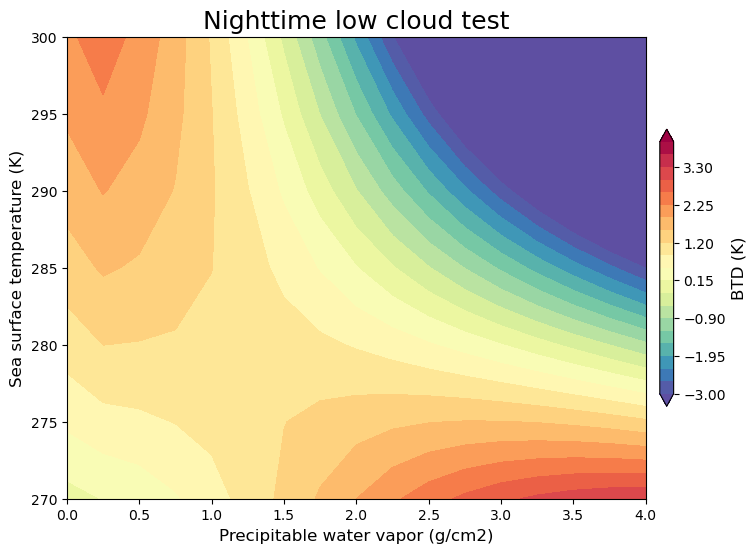

In [12]:
fig,ax=plt.subplots(1, figsize=(9,6))
cmap = plt.cm.Spectral_r
levels = np.linspace(-3, 4, 21)

c=ax.contourf(uw_grid, temp_grid, btd_grid, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.6, pad=0.02, ax=ax)
ax.set_title('Nighttime low cloud test', fontsize=18)
ax.set_ylabel('Sea surface temperature (K)', fontsize=12)
ax.set_xlabel('Precipitable water vapor (g/cm2)', fontsize=12)
clb.set_label('BTD (K)', fontsize=12)
plt.savefig('sbdart_sst_wv.png', dpi=200, bbox_inches='tight')